In [63]:
#IMPORT Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm

from cmdstanpy import cmdstan_path, CmdStanModel
import arviz as az
import seaborn as sns

from tensorflow_probability.substrates import numpy as tfp

In [64]:
#import STAN
from cmdstanpy import install_cmdstan
install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: /Users/andrea/.cmdstan
CmdStan version 2.31.0 already installed


True

In [65]:
all_data = pd.read_csv("../Dataset/traintransf.csv", sep=';', header=0)
y_train = all_data['price']
X_train = all_data.drop('price', axis=1)

In [84]:
#Preparing data for running STAN
N = X_train.shape[0]
beta_0 = np.ones(N) * 1
X_train['Intercept'] = beta_0

X_model = np.array(X_train.drop('Neighborhood', axis=1))	# fixed effect variables
Z_model = beta_0 	# group effect variables

group = np.array(X_train['Neighborhood'].copy())
neighborhood_name = np.unique(group)
for i, n in enumerate(neighborhood_name):
	group[group == n] = i + 1
group = np.array(group, dtype="int")

P = X_model.shape[1]
K = 1 #Z_model.shape[1]
M = len(np.unique(group))

X_model = np.reshape(X_model, (N, P))
Z_model = np.reshape(Z_model, (N, K))

alpha0 = 1		# outcome stdev shape
sigma0 = 30	# outcome stdev scale
beta0 = 0.05		# fixed effect stdev shape
tau0 = 1			# fixed effect stdev scale
eta0 = 0.05			# group effect stdev shape
xi0 = 1				# group effect stdev scale

theta0 = np.zeros(P) # mean of fixed effect parameters
gamma0 = np.zeros(K) # mean of group effect parameters

In [67]:
#Running the Stan Model
stan_file = "./model-mixed-uni-log.stan"
stan_model = CmdStanModel(stan_file=stan_file)

model_mixed_data = {
  "N": N,						# number of data items
  "P": P,						# number of fixed effect covariates
  "K": K,						# number of group effect covariates
  "M": M,						# number of groups
  
  "y": y_train,			# outcome vector
  "group": group,		# neighborhood assignment
  
  "x": X_model,			# fixed effect covariate matrix
  "z": Z_model,			# group effect covariate matrix

  "alpha0": alpha0,	# sigma shape
	"sigma0": sigma0,	# sigma scale
  "beta0": beta0,		# tau shape
	"tau0": tau0,			# tau scale
  "eta0": eta0,			# xi shape
  "xi0": xi0,				# xi scale
  
  "theta0": theta0,	# mean of fixed effect parameters
  "gamma0": gamma0	# mean of group effect parameters
}

stan_fit = stan_model.sample(
	data=model_mixed_data,
	chains=4,
	parallel_chains=4,
	iter_warmup=1000,
	iter_sampling=5000
)

DEBUG:cmdstanpy:found newer exe file, not recompiling
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7nairj_5/q83_dtub.json
DEBUG:cmdstanpy:cmd: /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/Bayesian Statistics Project/Linear Mixed Model/model-mixed-uni-log info
cwd: None
18:11:11 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/Bayesian Statistics Project/Linear Mixed Model/model-mixed-uni-log', 'id=1', 'random', 'seed=16956', 'data', 'file=/tmp/tmp7nairj_5/q83_dtub.json', 'output', 'file=/tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/Bayesian Statistics Project/Linear Mixed Model/model-mixed-uni-log', 'id=2', 'random', 'seed=16956', 'data', 'file=/tmp/tmp7nairj_5/q

18:13:15 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/Bayesian Statistics Project/Linear Mixed Model/model-mixed-uni-log', 'id=1', 'random', 'seed=16956', 'data', 'file=/tmp/tmp7nairj_5/q83_dtub.json', 'output', 'file=/tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_1.csv
 console_msgs (if any):
	/tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)


In [68]:
#Save or Load the Model with pickle if necessary
import pickle

with open('stan_mixed_fit.pickle', 'wb') as f:
	pickle.dump(stan_fit, f)

#with open('./stan_mixed_fit.pickle', 'rb') as f:
#	stan_fit = pickle.load(f)

In [69]:
print(stan_fit.diagnose())

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/diagnose /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_1.csv /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_2.csv /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_3.csv /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_4.csv
cwd: None


Processing csv files: /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_1.csv, /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_2.csv, /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_3.csv, /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [70]:
fit = stan_fit.summary()
fit

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp7nairj_5/stansummary-model-mixed-uni-log-f11_tphm.csv /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_1.csv /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_2.csv /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_3.csv /tmp/tmp7nairj_5/model-mixed-uni-logymhms6yw/model-mixed-uni-log-20230211181111_4.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,2831.080000,0.056367,4.665800,2822.970000,2831.390000,2838.150000,6851.72000,19.52660,1.000410
theta[1],0.050284,0.000046,0.004515,0.042895,0.050265,0.057740,9645.02000,27.48710,1.000360
theta[2],0.011697,0.000022,0.002454,0.007646,0.011714,0.015697,12890.50000,36.73630,1.000100
theta[3],0.008632,0.000022,0.002162,0.005067,0.008609,0.012189,9269.78000,26.41780,1.000220
theta[4],0.007671,0.000038,0.003426,0.002087,0.007612,0.013486,8274.06000,23.58010,1.000440
theta[5],0.025404,0.000105,0.009637,0.009437,0.025322,0.041357,8383.53000,23.89210,1.000000
theta[6],0.000239,0.000002,0.000230,0.000013,0.000170,0.000700,19307.50000,55.02400,1.000070
theta[7],0.002021,0.000011,0.001365,0.000204,0.001824,0.004566,15010.20000,42.77720,0.999944
theta[8],0.013398,0.000030,0.003025,0.008458,0.013391,0.018364,9959.76000,28.38410,1.000380
theta[9],0.025232,0.000064,0.006947,0.013718,0.025242,0.036601,11777.10000,33.56330,0.999984


In [85]:
#Computing log( f(y | theta, ...) ) for every y at every step

colname = stan_fit.draws_pd().columns
#print(colname)

theta = np.array(stan_fit.draws_pd()[colname[7:18]])
gamma = np.array(stan_fit.draws_pd()[colname[18:45]])
sigma = np.array(stan_fit.draws_pd()[colname[45]])

#print(theta.shape)
#print(gamma.shape)
#print(sigma.shape)

T = 20000
log_fy = np.zeros((N,T))
mean_log_fy = np.zeros(N)
mix_eff = np.zeros((N,T))

for i in range(N):
    mix_eff[i,] +=  np.transpose(gamma)[group[i]-1,]
    
mu = np.matmul(X_model, np.transpose(theta)) + mix_eff

sigma_sqrt = np.sqrt(sigma)

for i in range(N):
    log_fy[i,] = np.log(norm.pdf(y_train[i], mu[i,], sigma_sqrt))

In [86]:
#Computing WAIC
mean_log_fy = np.mean(log_fy,axis=1)
lppd = mean_log_fy.sum()

variance = np.zeros(N)
for i in range(N):
    variance[i] = ((log_fy[i,] - mean_log_fy[i])**2).mean()
pW = variance.sum()

WAIC = -2*lppd + 2*pW
print(WAIC)


-3969.307673455864


/Users/andrea/miniforge3/lib/python3.10/site-packages/arviz/plots/traceplot.py:215: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (41), generating only 20 plots
  warnings.warn(


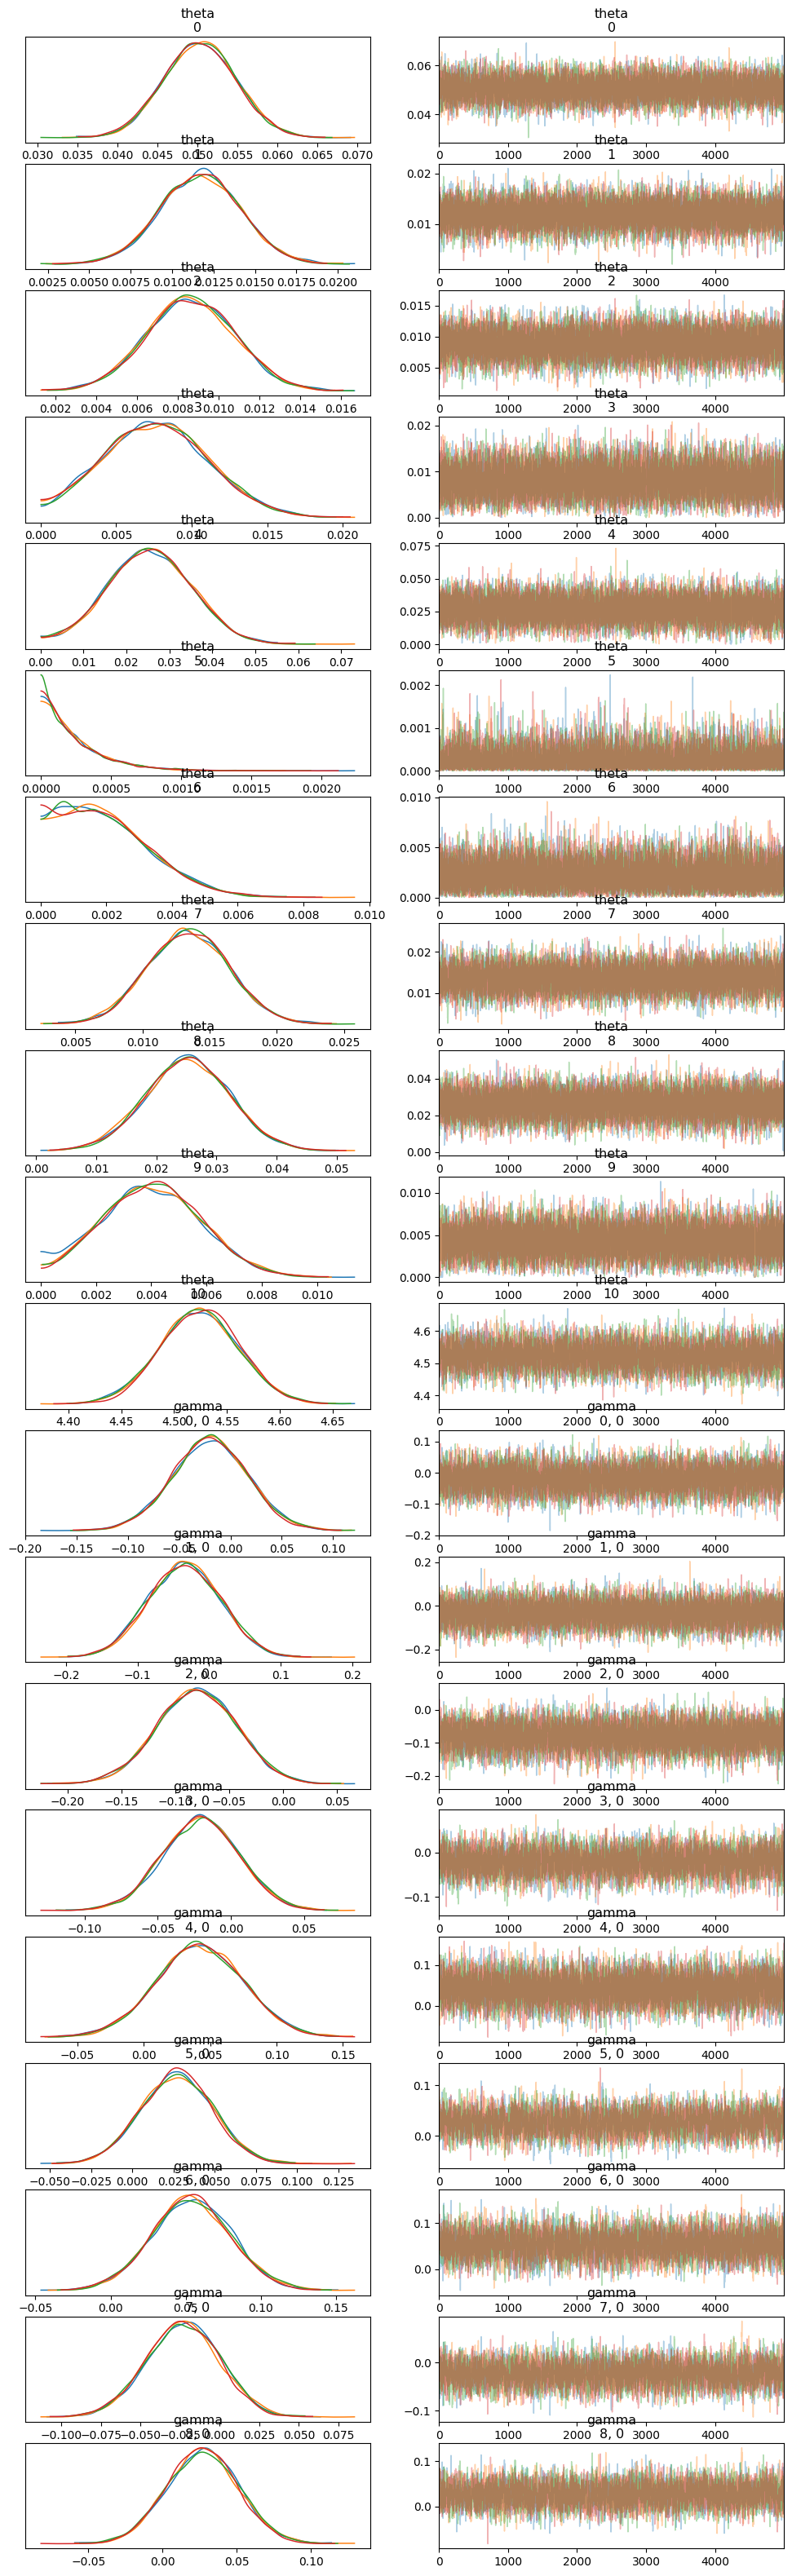

In [73]:
#FIT PLOT
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
az.plot_trace(cmdstanpy_data, compact=False)
plt.show()

In [74]:
# Pre-processing for final plots

# stan_fit.summary().iloc[2]
theta_idx = list(range(1, 1 + P))
gamma_idx = [list(range(1, 1 + K)) for i in range(1, 1 + M)] # range(1 + P, 1 + P + M*K)

theta_intervals = {}

for i in theta_idx:
	output = fit.iloc[i]
	theta_intervals[i] = {
		'5': output['5%'],
		'50': output['50%'],
		'95': output['95%'],
		'containsZero': (output['5%'] * output['95%'] <= 0)
	}

gamma_intervals = {}

for i, l in enumerate(gamma_idx):
	for j in l:
		output = fit.iloc[P + i * K + j]
		gamma_intervals[i + 1, j] = {
			'5': output['5%'],
			'50': output['50%'],
			'95': output['95%'],
			'containsZero': (output['5%'] * output['95%'] <= 0)
		}
	
theta_intervals = dict(sorted(theta_intervals.items(), key=lambda item: item[1]['50']))
gamma_intervals = dict(sorted(gamma_intervals.items(), key=lambda item: item[1]['50']))

theta_intervals_nonzero = {
	k: v for k, v in theta_intervals.items() if not v['containsZero']
}

gamma_intervals_nonzero = {
	k: v for k, v in gamma_intervals.items() if not v['containsZero']
}

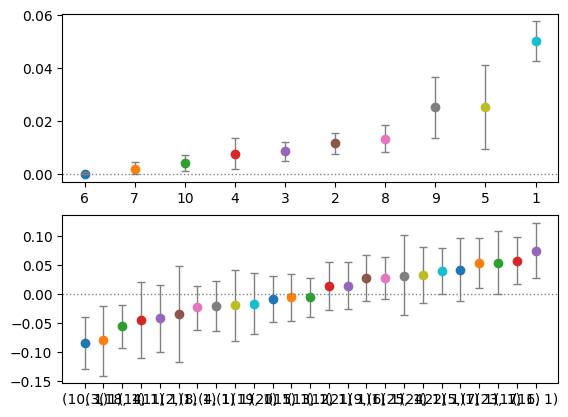

In [75]:
# Final Plots
fig, axes = plt.subplots(nrows=2)
intervals = [
	{k: v for k, v in theta_intervals.items() if k != 11},
	gamma_intervals
]

for ax in axes:
	interval = intervals.pop(0)
	ax.axhline(y=0, color='grey', linestyle='dotted', linewidth=1)
	for i, k in enumerate(interval.keys()):
		ax.vlines(
			x=str(k),
			ymin=interval[k]['5'],
			ymax=interval[k]['95'],
			colors=['grey'],
			linewidth=1,
			zorder=0
		)
		ax.scatter(x=str(k), y=interval[k]['50'], zorder=1)
		ax.scatter(x=str(k), y=interval[k]['5'], color='grey', marker='_', linewidths=1)
		ax.scatter(x=str(k), y=interval[k]['95'], color='grey', marker='_', linewidths=1)

plt.show()

## Prediction

In [76]:
test_data = pd.read_csv("../Dataset/testtransf.csv", sep=';', header=0)
y_test = test_data['price']
X_test = test_data.drop('price', axis=1)

In [77]:
#Preparing data for testing
N = X_test.shape[0]
beta_0 = np.ones(N) * 1
X_test['Intercept'] = beta_0

X_pred = np.array(X_test.drop('Neighborhood', axis=1))	# fixed effect variables
Z_pred = beta_0 	# group effect variables

test_group = np.array(X_test['Neighborhood'].copy())
neighborhood_name = np.unique(test_group)
for i, n in enumerate(neighborhood_name):
	test_group[ test_group==n ] = i + 1
test_group = np.array(test_group, dtype="int")

P = X_pred.shape[1]
K = 1 #Z_model.shape[1]
M = len(np.unique(group))

X_pred = np.reshape(X_pred, (N, P))
Z_pred = np.reshape(Z_pred, (N, K))

In [78]:
y_pred = np.zeros((N, T))

mix_eff = np.zeros((N,T))
for i in range(N):
    mix_eff[i,] +=  np.transpose(gamma)[test_group[i]-1,]
    
mu = np.matmul(X_pred, np.transpose(theta)) + mix_eff

sigma_sqrt = np.sqrt(sigma)

np.random.default_rng(seed=42)
for i in range(N):
    y_pred[i,] = np.random.normal( loc = mu[i,], scale = sigma_sqrt)

predictions = y_pred.mean(axis=1)
pd.DataFrame(predictions, columns=["predicted"]).to_csv("./TestPred.csv")

In [79]:
SSE = (y_pred.mean(axis=1) - y_test)**2
print(SSE.sum())
print(np.sqrt(SSE.mean()))

2.938653469476916
0.07075467453422771


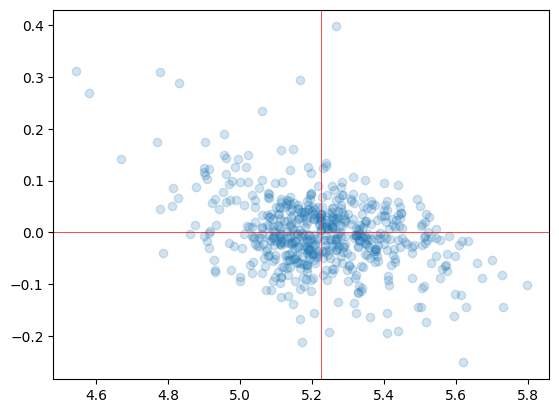

In [80]:
plt.scatter(x = y_test,y = y_pred.mean(axis=1) - y_test, alpha = 0.2)
plt.axvline(x=y_test.mean(), color = 'red', linewidth=0.5)
plt.axhline(y=0, color = 'red', linewidth=0.5)
plt.show()

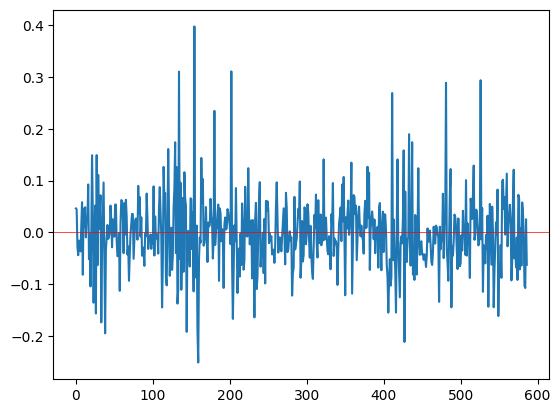

In [81]:
plt.plot(y_pred.mean(axis=1) - y_test)
plt.axhline(y=0, color = 'red', linewidth=0.5)
plt.show()